# Long Short Term Memory Model of stock prediction 

## Abnormal Stock
## 300431.SZ BaoFeng Tech. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
rnn_unit = 10       #hidden layer level
input_size = 6
output_size = 1
lr = 0.0005         #learning rate

In [4]:
df=pd.read_csv('300431.csv')     
data=df.iloc[:,1:8].values  
n = len(df)
train_ratio = 0.7   #decide the data ratio as training data
save_name ='model_save4\\model.ckpt'
cpt_name ='model_save4'

## generating the standardized training data

In [5]:
def get_train_data(batch_size=60, time_step=20, train_begin=0, train_end=int(n*train_ratio)):
    batch_index=[]
    data_train=data[train_begin:train_end]
    normalized_train_data=(data_train-np.mean(data_train,axis=0))/np.std(data_train,axis=0)  
    train_x,train_y=[],[]   
    for i in range(len(normalized_train_data)-time_step):
        if i % batch_size==0:
            batch_index.append(i)
        x = normalized_train_data[i:i+time_step,:input_size]
        y = normalized_train_data[i:i+time_step,input_size,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data)-time_step))
    return batch_index,train_x,train_y

## generating the standardized test data

In [6]:
def get_test_data(time_step=20, test_begin=int(n*train_ratio)):
    data_test=data[test_begin:]
    mean=np.mean(data_test,axis=0)
    std=np.std(data_test,axis=0)
    normalized_test_data=(data_test-mean)/std  
    size=(len(normalized_test_data)+time_step-1)//time_step  
    test_x,test_y=[],[]
    for i in range(size-1):
        x=normalized_test_data[i*time_step:(i+1)*time_step,:input_size]
        y=normalized_test_data[i*time_step:(i+1)*time_step,input_size]
        test_x.append(x.tolist())
        test_y.extend(y)
    test_x.append((normalized_test_data[(i+1)*time_step:,:input_size]).tolist())
    test_y.extend((normalized_test_data[(i+1)*time_step:,input_size]).tolist())
    return mean,std,test_x,test_y

## setting the weights and biases

In [7]:
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
        }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
       }

## set the LSTM model

In [8]:
def lstm(X):
    
    batch_size=tf.shape(X)[0]
    time_step=tf.shape(X)[1]
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  
    cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)
    output=tf.reshape(output_rnn,[-1,rnn_unit]) 
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

## generating the training function

In [9]:
def train_lstm(save_name, batch_size=60, time_step=20, train_begin=0, train_end=int(n*train_ratio), iteration=100):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    batch_index,train_x,train_y=get_train_data(batch_size, time_step, train_begin, train_end)
    with tf.variable_scope("sec_lstm"):
        pred,_=lstm(X)
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables(),max_to_keep=15)
    #module_file = tf.train.latest_checkpoint()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #saver.restore(sess, module_file)
        for i in range(iteration):     
            for step in range(len(batch_index)-1):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]]})
            print("Number of iterations:",i," loss:",loss_)
        print("model_save: ",saver.save(sess,save_name))
        print("The train has finished")

## run the training
### (there is still some troubles that if you want to re-train the model, you must re-open the jupyter notebook）

In [10]:
train_lstm(save_name)

Number of iterations: 0  loss: 1.0160315
Number of iterations: 1  loss: 0.90580624
Number of iterations: 2  loss: 0.80519974
Number of iterations: 3  loss: 0.71533626
Number of iterations: 4  loss: 0.6363173
Number of iterations: 5  loss: 0.5677784
Number of iterations: 6  loss: 0.50910413
Number of iterations: 7  loss: 0.45954552
Number of iterations: 8  loss: 0.4182764
Number of iterations: 9  loss: 0.38441536
Number of iterations: 10  loss: 0.35703692
Number of iterations: 11  loss: 0.3351883
Number of iterations: 12  loss: 0.3179166
Number of iterations: 13  loss: 0.30430555
Number of iterations: 14  loss: 0.29351318
Number of iterations: 15  loss: 0.2848038
Number of iterations: 16  loss: 0.27756828
Number of iterations: 17  loss: 0.27133077
Number of iterations: 18  loss: 0.26574337
Number of iterations: 19  loss: 0.26056972
Number of iterations: 20  loss: 0.2556645
Number of iterations: 21  loss: 0.2509506
Number of iterations: 22  loss: 0.24639662
Number of iterations: 23  loss

## prediciton part

In [11]:
def prediction(cpt_name, time_step=20):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    mean,std,test_x,test_y=get_test_data(time_step)
    with tf.variable_scope("sec_lstm",reuse=True):
        pred,_=lstm(X)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        module_file = tf.train.latest_checkpoint(cpt_name)
        saver.restore(sess, module_file)
        test_predict=[]
        for step in range(len(test_x)-1):
            prob=sess.run(pred,feed_dict={X:[test_x[step]]})
            predict=prob.reshape((-1))
            test_predict.extend(predict)
        test_y=np.array(test_y)*std[input_size]+mean[input_size]
        test_predict=np.array(test_predict)*std[input_size]+mean[input_size]
        min_index = min(len(test_y),len(test_predict))
        test_y = test_y[:min_index]
        test_predict = test_predict[:min_index]
    return test_predict,test_y

## plot function

In [12]:
def plot_result(x, y,label,save_dir):     
    plt.figure()
    plt.plot(list(range(len(x))), x, color='b',)
    plt.plot(list(range(len(y))), y, color='r')
    plt.legend(label,loc=0)
    plt.savefig(save_dir)
    plt.show()

## My trading strategy
### since we have predicted the return, we make simple trading strategy:
### If the predicted return tomorrow is positive, you are buying or still owing the stock by the end of closing
### If the predicted return tomorrow is negative, you are selling or keeping no shares by the end of closing

### tips:1.we consider the trading cost as 0.3%
###         2.The buying or selling price is close to the ClosePrice that day

In [13]:
def buy_signal(test_predict,test_y):
    cost = 0.003
    new_nv =[1]
    sig = test_predict > 0
    for i in range(len(sig)-1):
        if (sig[i+1] == True) and (sig[i] == True):
            new_nv.append(new_nv[-1]*(1+test_y[i]))
        elif (sig[i+1] == True) and (sig[i] == False):
            new_nv.append(new_nv[-1]*(1-cost))
        elif (sig[i+1] == False) and (sig[i] == False):
            new_nv.append(new_nv[-1])
        elif (sig[i+1] == False) and (sig[i] == True):
            new_nv.append(new_nv[-1]*(1+test_y[i])*(1-cost))
    return new_nv

In [14]:
def fit_nv(test_predict,test_y):
    ynv = [1]
    prenv = [1]
    for i in range(len(test_predict)):
        ynv.append(ynv[-1]*(1+test_y[i]))
        prenv.append(prenv[-1]*(1+test_predict[i]))
    plot_result(prenv,ynv,['predict net value','test net value'])

## Prediction  result

INFO:tensorflow:Restoring parameters from model_save4\model.ckpt


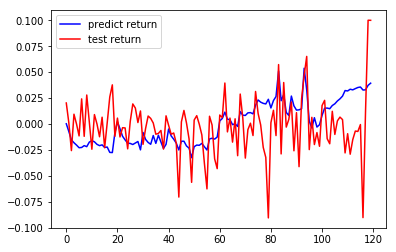

In [15]:
test_predict,test_y = prediction(cpt_name)
plot_result(test_predict, test_y,['predict return','test return'],'result4_1.png')

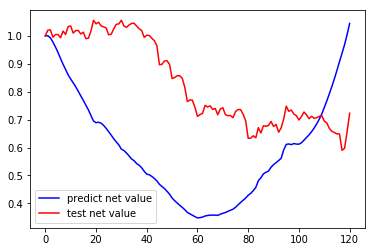

In [16]:
ynv = [1]
prenv = [1]    
def fit_nv(test_predict,test_y):
    for i in range(len(test_predict)):
        ynv.append(ynv[-1]*(1+test_y[i]))
        prenv.append(prenv[-1]*(1+test_predict[i]))
    plot_result(prenv,ynv,['predict net value','test net value'],'result4_2.png')
fit_nv(test_predict,test_y)

## My trading strategy result

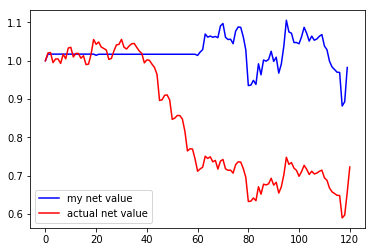

In [17]:
new_nv = buy_signal(test_predict,test_y)   
plot_result(new_nv,ynv,['my net value','actual net value'],'result4_3.png')

In [18]:
num = 0
for i in range(len(test_y)):
    if np.sign(test_predict[i])== np.sign(test_y[i]):
        num = num + 1
acc = num / len(test_y)
acc

0.55